In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import warnings
warnings.filterwarnings("ignore")
import os
import pathlib

inputdir = "/Volumes/HNWD02/outdir/output_methyl_ReadBased_Models/01_output/TSMA_panel"
path_to_all_fa = "/Volumes/HNSD01/storage/ref/hg19"
outdir = "/Volumes/HNSD01/outdir"
outputdir = os.path.join(outdir, "output_methyl_ReadBased_Models")
path_to_01_output = os.path.join(outputdir, "01_output")
path_to_02_output = os.path.join(outputdir, "02_output")
path_to_03_output = os.path.join(outputdir, "03_output")
os.system(f"mkdir -p {path_to_03_output}")

region = "11_46723163_46723254"

df = pd.read_csv(os.path.join(path_to_02_output, f"{region}_methylString.csv"), index_col = [0])
cpg_coords = [item for item in df.columns if item not in 
["methyl_string", "SampleID","cover","LABCODE","TYPE"] ]

df = df[df["cover"] == df["cover"].max()]

# Filter rows where all cpg_coord columns are either 0 or 1
maskdf = pd.DataFrame()
for c in cpg_coords:
    maskdf[c] = [df[df[c].isin([0,1])].shape[0]]
maskdf = maskdf.T.reset_index()
full_cover_cpgs = maskdf[maskdf[0] == df.shape[0]]["index"].tolist()
df = df[full_cover_cpgs + ["methyl_string", "SampleID","cover","LABCODE","TYPE"]]
df["full_cover_methyl_string"] = df[full_cover_cpgs].astype(str).agg(''.join, axis=1)

In [3]:
tsmadf = pd.read_excel("/Users/hieunguyen/src/tsma_micro_atlas/assets/12967_2024_5416_MOESM1_ESM.xlsx")
tsmadf[tsmadf["Region_name"] == region]

,Region_name,Group,chromosome,coord.Start,coord.End,symbol
580,11_46723163_46723254,Lung,11,46723163,46723254,ZNF408


<Axes: xlabel='SampleID', ylabel='full_cover_methyl_string'>

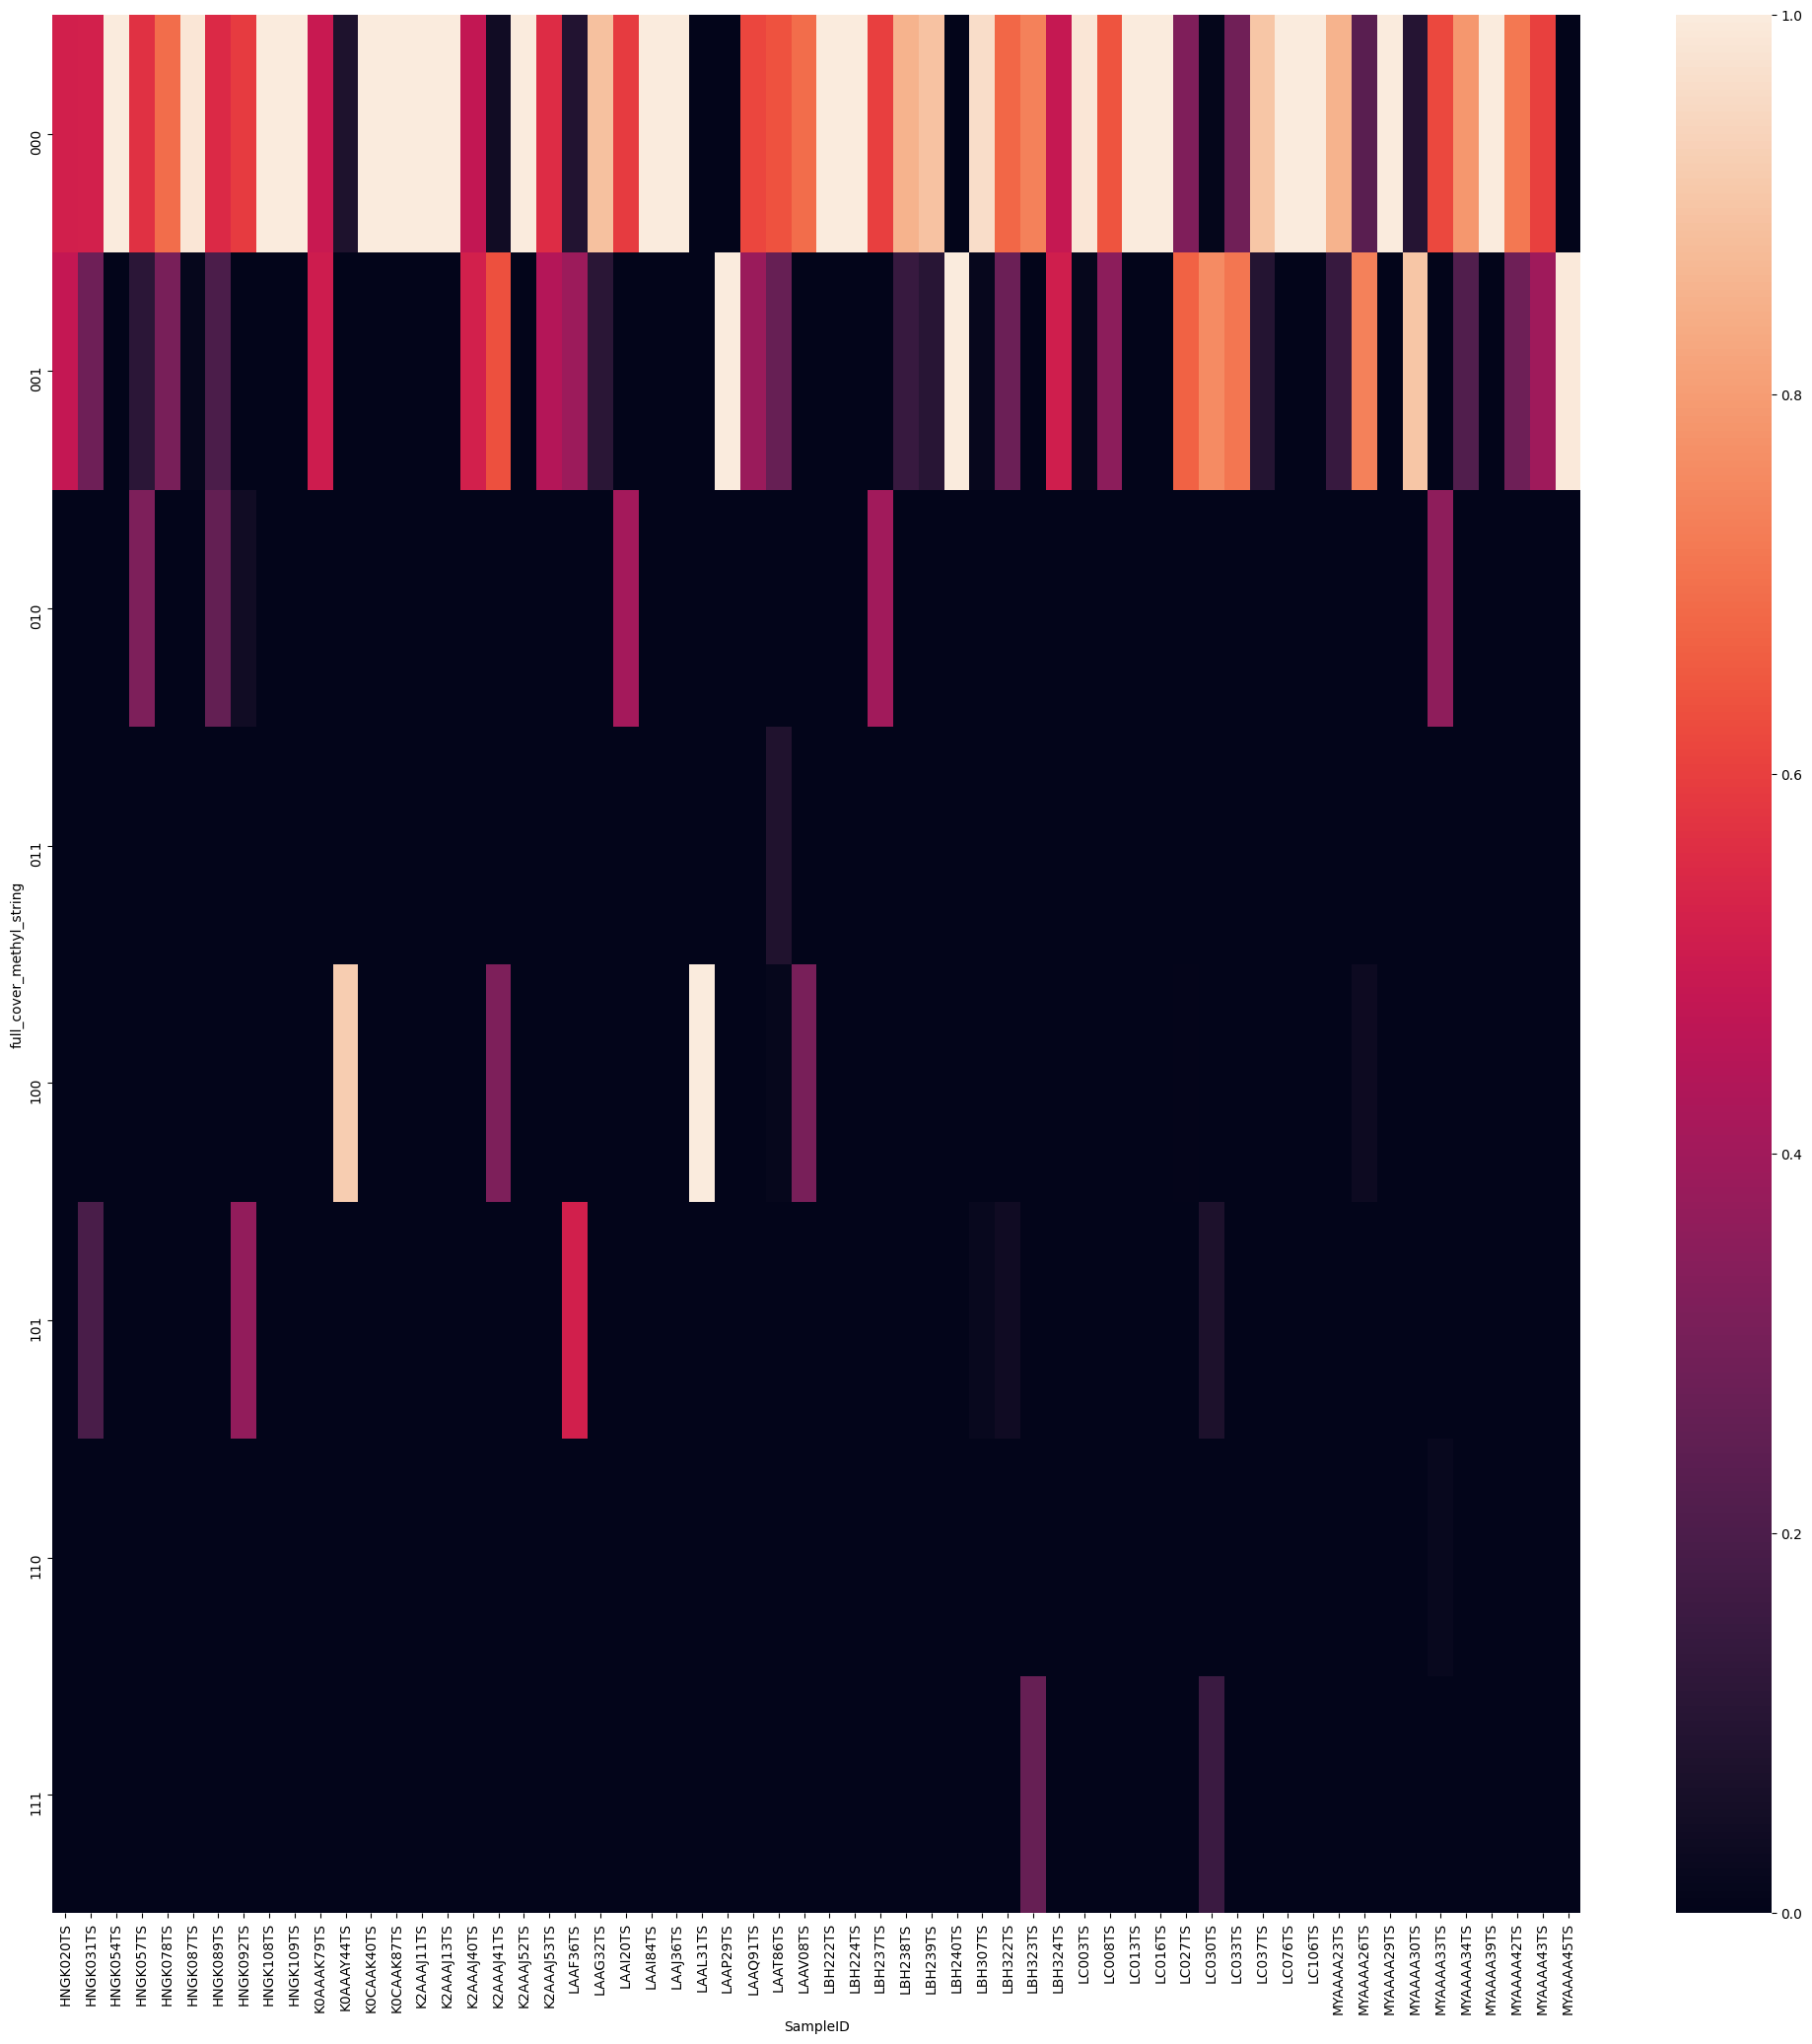

In [4]:
dfcount = df.groupby(["SampleID", "full_cover_methyl_string"])["TYPE"].count().reset_index()
dfcount_wide = dfcount.pivot(index='full_cover_methyl_string', columns='SampleID', values='TYPE').fillna(0)
for n in dfcount_wide.columns:
    dfcount_wide[n] = dfcount_wide[n]/dfcount_wide[n].sum()

plt.figure(figsize=(25,25))
sns.heatmap(dfcount_wide)

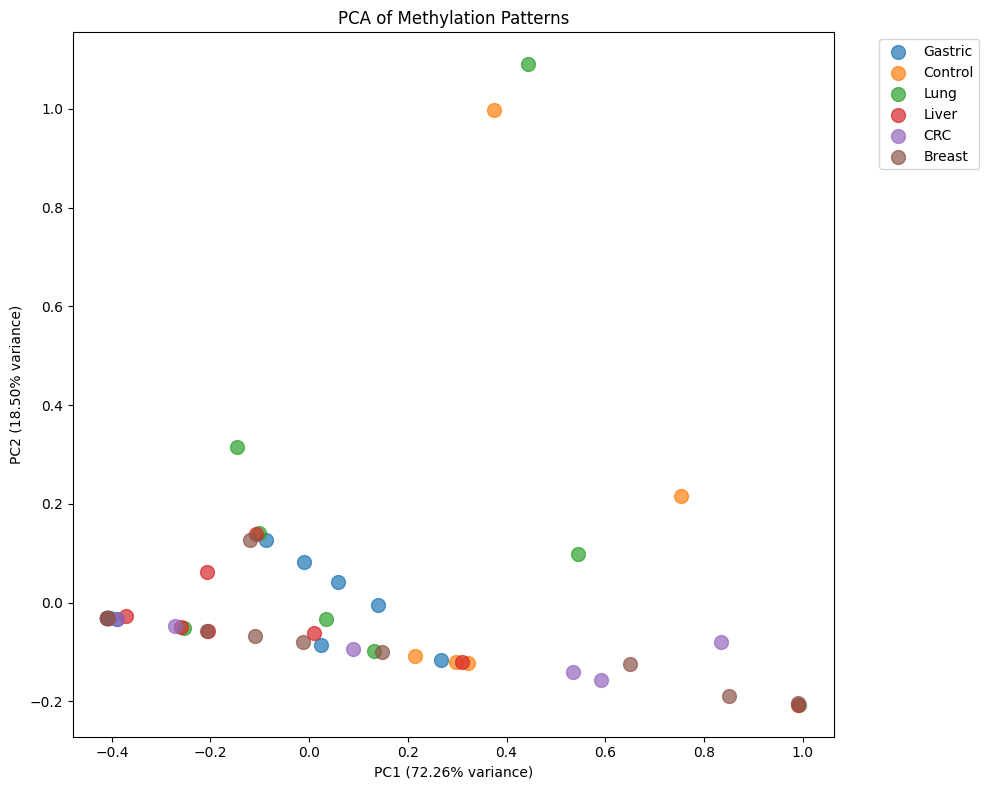

In [5]:
from sklearn.decomposition import PCA

# First, we need to extract sample metadata from df
# Get unique sample information (SampleID and TYPE)
metadata = df[['SampleID', 'TYPE']].drop_duplicates().set_index('SampleID')

# Perform PCA

# Transpose dfcount_wide so samples are rows
dfcount_wide_T = dfcount_wide.T

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dfcount_wide_T)

# Create a dataframe with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=dfcount_wide_T.index)

# Add TYPE information from metadata
pca_df['TYPE'] = pca_df.index.map(metadata['TYPE'])

# Plot PCA
plt.figure(figsize=(10, 8))
for tissue_type in pca_df['TYPE'].unique():
    subset = pca_df[pca_df['TYPE'] == tissue_type]
    plt.scatter(subset['PC1'], subset['PC2'], label=tissue_type, s=100, alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA of Methylation Patterns')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Axes: xlabel='SampleID', ylabel='full_cover_methyl_string'>

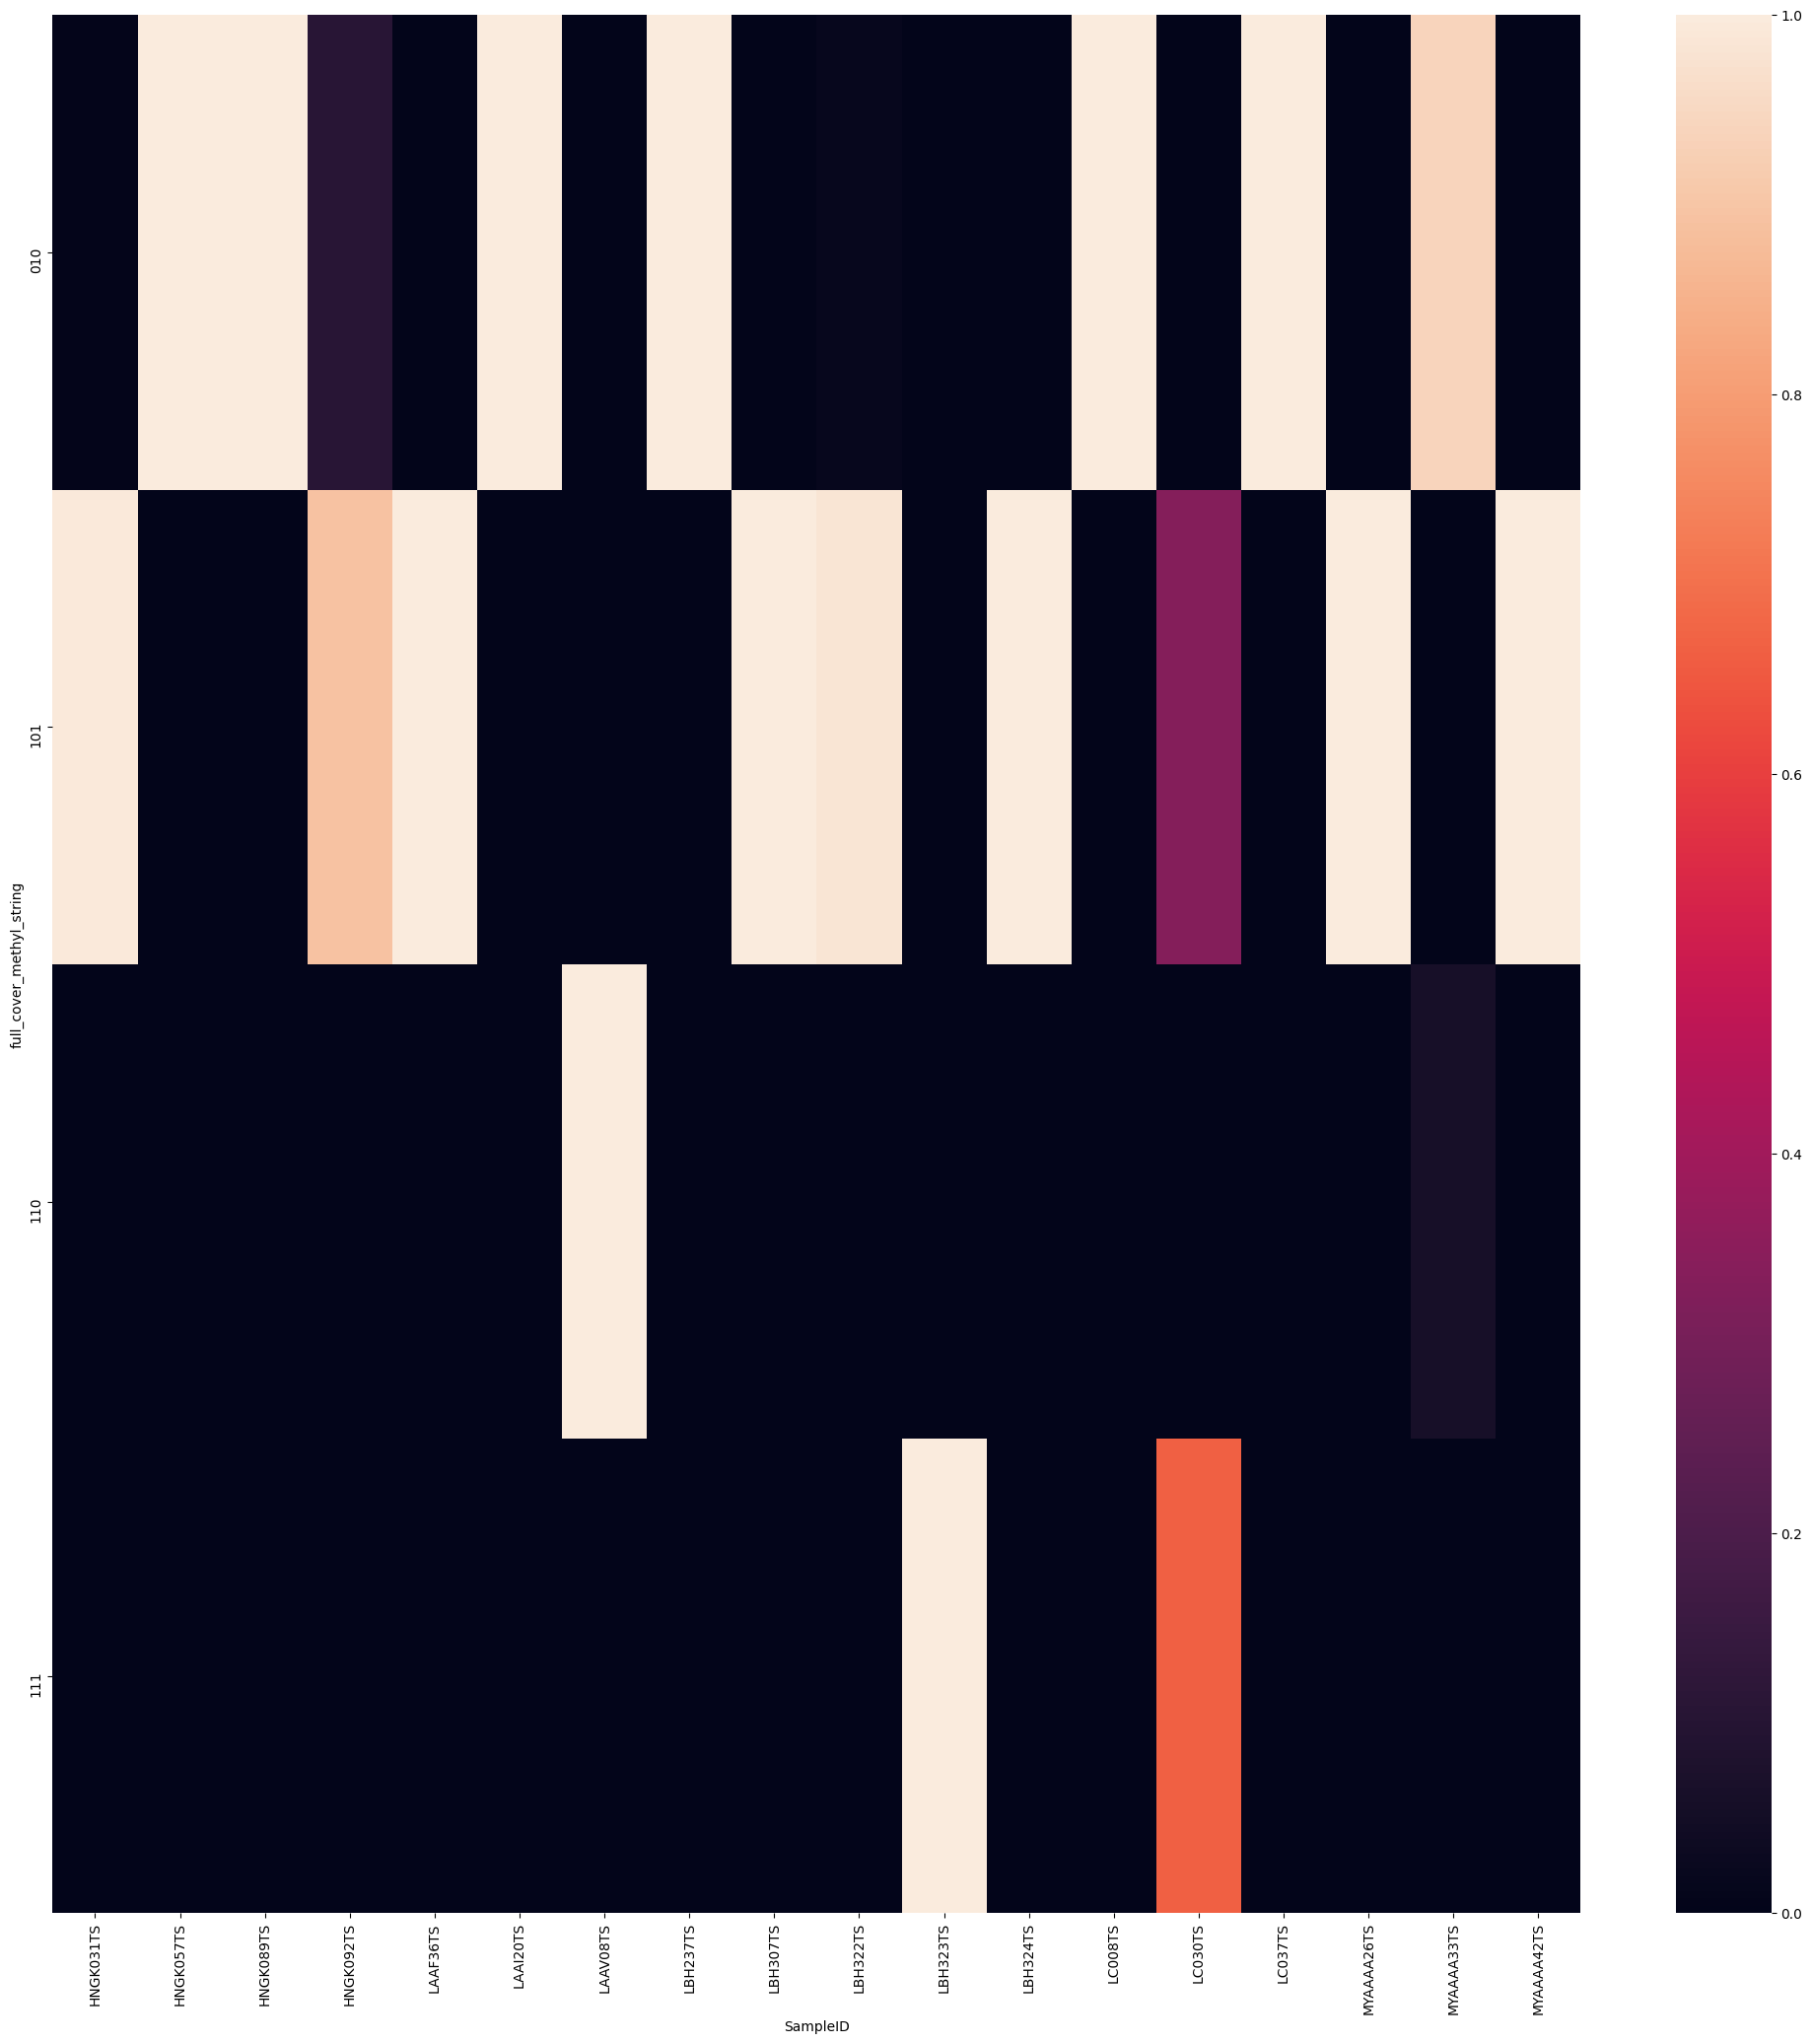

In [12]:
wbc_patterns = df[df["TYPE"] == "Control"].full_cover_methyl_string.unique()

df_nowbc = df[df["full_cover_methyl_string"].isin(wbc_patterns) == False]


dfcount = df_nowbc.groupby(["SampleID", "full_cover_methyl_string"])["TYPE"].count().reset_index()
dfcount_wide = dfcount.pivot(index='full_cover_methyl_string', columns='SampleID', values='TYPE').fillna(0)
for n in dfcount_wide.columns:
    dfcount_wide[n] = dfcount_wide[n]/dfcount_wide[n].sum()

plt.figure(figsize=(25,25))
sns.heatmap(dfcount_wide)

In [18]:
df_nowbc.groupby(["TYPE", "SampleID"]).count()

46723199  46723215  46723243  methyl_string  cover  \
TYPE    SampleID                                                         
Breast  MYAAAA26TS         1         1         1              1      1   
        MYAAAA33TS       759       759       759            759    759   
        MYAAAA42TS         3         3         3              3      3   
CRC     LC008TS            1         1         1              1      1   
        LC030TS          246       246       246            246    246   
        LC037TS            1         1         1              1      1   
Gastric HNGK031TS        224       224       224            224    224   
        HNGK057TS        479       479       479            479    479   
        HNGK089TS        851       851       851            851    851   
        HNGK092TS       2324      2324      2324           2324   2324   
Liver   LBH237TS        1203      1203      1203           1203   1203   
        LBH307TS           5         5         5              5      5   
        LBH322TS         223       223       223            223    223   
        LBH323TS         342       342       342            342    342   
        LBH324TS           1         1         1              1      1   
Lung    LAAF36TS        2766      2766      2766           2766   2766   
        LAAI20TS         934       934       934            934    934   
        LAAV08TS           1         1         1              1      1   

                    LABCODE  full_cover_methyl_string  
TYPE    SampleID                                       
Breast  MYAAAA26TS        1                         1  
        MYAAAA33TS      759                       759  
        MYAAAA42TS        3                         3  
CRC     LC008TS           1                         1  
        LC030TS         246                       246  
        LC037TS           1                         1  
Gastric HNGK031TS       224                       224  
        HNGK057TS       479                       479  
        HNGK089TS       851                       851  
        HNGK092TS      2324                      2324  
Liver   LBH237TS       1203                      1203  
        LBH307TS          5                         5  
        LBH322TS        223                       223  
        LBH323TS        342                       342  
        LBH324TS          1                         1  
Lung    LAAF36TS       2766                      2766  
        LAAI20TS        934                       934  
        LAAV08TS          1                         1

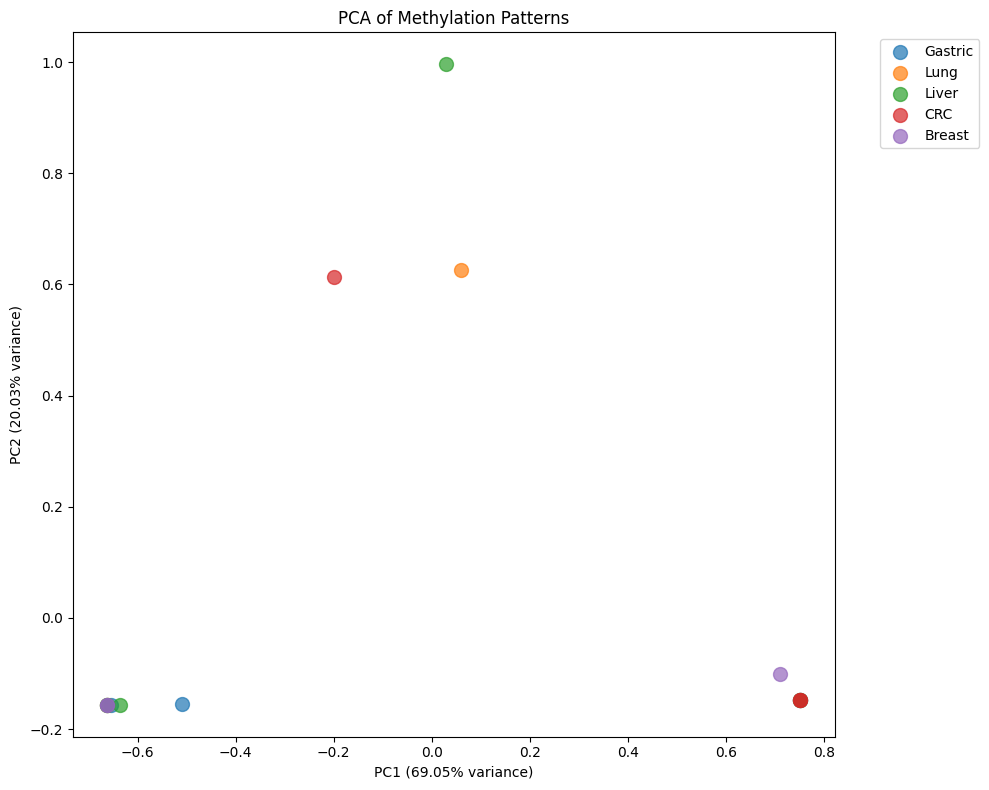

In [13]:
from sklearn.decomposition import PCA

# First, we need to extract sample metadata from df
# Get unique sample information (SampleID and TYPE)
metadata = df[['SampleID', 'TYPE']].drop_duplicates().set_index('SampleID')

# Perform PCA

# Transpose dfcount_wide so samples are rows
dfcount_wide_T = dfcount_wide.T

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dfcount_wide_T)

# Create a dataframe with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=dfcount_wide_T.index)

# Add TYPE information from metadata
pca_df['TYPE'] = pca_df.index.map(metadata['TYPE'])

# Plot PCA
plt.figure(figsize=(10, 8))
for tissue_type in pca_df['TYPE'].unique():
    subset = pca_df[pca_df['TYPE'] == tissue_type]
    plt.scatter(subset['PC1'], subset['PC2'], label=tissue_type, s=100, alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA of Methylation Patterns')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()